In [1]:
!rm -rf /kaggle/working/multimodal-eq-sizing
!git clone https://github.com/brianrp09232000/multimodal-eq-sizing.git /kaggle/working/multimodal-eq-sizing
!pip install -r /kaggle/working/multimodal-eq-sizing/requirements.txt

Cloning into '/kaggle/working/multimodal-eq-sizing'...
remote: Enumerating objects: 731, done.
remote: Counting objects: 100% (205/205), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 731 (delta 136), reused 104 (delta 91), pack-reused 526 (from 1)
Receiving objects: 100% (731/731), 591.52 KiB | 3.52 MiB/s, done.
Resolving deltas: 100% (450/450), done.


In [2]:
import sys
import pathlib
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf

In [3]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
repo_root = pathlib.Path("/kaggle/working/multimodal-eq-sizing")
sys.path.append(str(repo_root))

In [46]:
sys.path

['/kaggle/working',
 '/kaggle/lib/kagglegym',
 '/kaggle/lib',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/kaggle/working/multimodal-eq-sizing',
 '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor',
 '/tmp/tmplyh_uozn']

In [5]:
from src.data.loaders import (
    get_single_ticker_history,
    get_tickers_history,
    get_return_data,
    get_excess_return,
    get_vix_data,
    get_spread_z,
    get_sector_map,
    get_adv_dollar
)

In [6]:
""" Active this code after PR approved
from src.data.features.price_features import (
compute_momentum_rank,
get_log_mktcap,
compute_SPY_r1
)
"""

' Active this code after PR approved\nfrom src.data.features.price_features import (\ncompute_momentum_rank,\nget_log_mktcap,\ncompute_SPY_r1\n)\n'

In [7]:
def get_date_range(df: pd.DataFrame) -> tuple:
    grouped_by_date = df.groupby(["ticker"]).agg(['min', 'max', 'count'])["Date"]
    start = grouped_by_date["min"].min()
    end = grouped_by_date["max"].max()
    return start, end

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shtrausslearning/news-trading")

print("Path to dataset files:", path)

df = pd.read_csv("/kaggle/input/news-trading/return_data.csv")

Path to dataset files: /kaggle/input/news-trading


In [9]:
df = get_return_data("/kaggle/input/news-trading/return_data.csv")
start, end = get_date_range(df)

# Add 12-1 momentum and momentum rank

In [10]:
def compute_momentum_rank(input_df):
    """
    Compute 12-1 momentum and cross-sectional momentum rank for each ticker.
    12-1 momentum = Close[t-21] / Close[t-252] - 1.
    cross-sectional rank each day = position / N.
    ----------
    Input dataset must contain columns ['ticker', 'Date']; 
    ----------
    Output dataset adds additional columns:['mom_12_1','mom_rank']
    """

    # Fetch data from yfinance starting at a buffer_start date to support 12–1 momentum calculations
    start = input_df['Date'].min() 
    end = input_df['Date'].max() 
    buffer_start = start - timedelta(days=400)
    df = get_tickers_history(list(input_df['ticker'].unique()), buffer_start, end)
    df = df.sort_values(['ticker', 'Date']).reset_index(drop=True)

    # Compute 12-1 momentum
    df['Close_t_21']  = df.groupby('ticker')['Close'].shift(21)
    df['Close_t_252'] = df.groupby('ticker')['Close'].shift(252)
    df['mom_12_1'] = df['Close_t_21'] / df['Close_t_252'] - 1

    # Compute cross-sectional 12-1 momentum ranking
    df['mom_position'] = (
        df.groupby('Date')['mom_12_1']
        .rank(method='first')
    )
    df['N'] = df.groupby('Date')['ticker'].transform('count')
    df['mom_rank'] = df['mom_position'] / df['N']

    # Drop buffer dates data; Keep mom_12_1 and mom_rank columns
    df2 = df[df['Date']>=start]
    df2 = df2[['Date','ticker','mom_12_1','mom_rank']]
    
    # Merge 12-1 momentum and rank into the input dataset
    output_df = pd.merge(input_df, df2, on =['ticker','Date'], how='left')
    return output_df

In [11]:
df = compute_momentum_rank(df)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,mom_12_1,mom_rank
0,2010-01-04 05:00:00+00:00,6.487649,6.520174,6.455732,6.505279,493729600,0.0,0.0,AAPL,1.162314,0.875
1,2010-01-05 05:00:00+00:00,6.523214,6.553307,6.482178,6.516527,601904800,0.0,0.0,AAPL,1.077395,0.875
2,2010-01-06 05:00:00+00:00,6.516527,6.542364,6.406185,6.412873,552160000,0.0,0.0,AAPL,1.078263,0.875
3,2010-01-07 05:00:00+00:00,6.436583,6.444183,6.354511,6.401018,477131200,0.0,0.0,AAPL,1.076144,0.875
4,2010-01-08 05:00:00+00:00,6.392506,6.444181,6.354814,6.443573,447610800,0.0,0.0,AAPL,1.048220,0.875
...,...,...,...,...,...,...,...,...,...,...,...
21904,2018-12-21 05:00:00+00:00,219.550003,222.259995,207.369995,208.800003,8828100,0.0,0.0,ADBE,0.261004,0.800
21905,2018-12-24 05:00:00+00:00,206.899994,212.580002,204.949997,205.160004,2940500,0.0,0.0,ADBE,0.294569,0.900
21906,2018-12-26 05:00:00+00:00,206.529999,222.960007,206.250000,222.949997,5897900,0.0,0.0,ADBE,0.288914,0.900
21907,2018-12-27 05:00:00+00:00,219.990005,225.169998,214.160004,225.139999,3931100,0.0,0.0,ADBE,0.329741,0.800


# Add log_mkt_cap

In [12]:
def get_log_mktcap(input_df):
    """
    Compute log(market capitalization) for each ticker.
    log(market cap_t) = log(Close_t) * SharesOutstanding. 
    * Note that Yahoo only provides the latest shares outstanding, so we don't have the historical 
    shares outstanding at time t. The calculation method for market capitalization may not be accurate.
    ----------
    Input dataset must contain columns ['ticker', 'Date']; 
    ----------
    Output dataset adds additional columns:['log_mktcap']
    """
    start = input_df['Date'].min() 
    end = input_df['Date'].max()
    tickers = list(input_df['ticker'].unique())
    
    rows = []
    for ticker in tickers:
        stock = yf.Ticker(ticker)

        # Get CURRENT shares outstanding
        shares = stock.info.get("sharesOutstanding", None)

        # Fetch historical price
        df_price = get_single_ticker_history(ticker, start, end)

        # Add ticker column
        df_price["ticker"] = ticker
        df_price = df_price.reset_index()

        # Compute market cap and log market cap
        if shares is not None:
            df_price["mktcap"] = df_price["Close"] * shares
            df_price["log_mktcap"] = (df_price["mktcap"]).apply(
                lambda x: None if pd.isna(x) else np.log(x)
            )
        else:
            df_price["market_cap"] = None
            df_price["log_mktcap"] = None

        rows.append(df_price)
    # concat all tickers and merge with the input dataset    
    mktcap = pd.concat(rows, ignore_index=True)[['Date','ticker','log_mktcap']]
    output_df = pd.merge(input_df, mktcap, on=['Date','ticker'], how='left')
    
    return output_df

In [13]:
df = get_log_mktcap(df)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,mom_12_1,mom_rank,log_mktcap
0,2010-01-04 05:00:00+00:00,6.487649,6.520174,6.455732,6.505279,493729600,0.0,0.0,AAPL,1.162314,0.875,25.275460
1,2010-01-05 05:00:00+00:00,6.523214,6.553307,6.482178,6.516527,601904800,0.0,0.0,AAPL,1.077395,0.875,25.277188
2,2010-01-06 05:00:00+00:00,6.516527,6.542364,6.406185,6.412873,552160000,0.0,0.0,AAPL,1.078263,0.875,25.261153
3,2010-01-07 05:00:00+00:00,6.436583,6.444183,6.354511,6.401018,477131200,0.0,0.0,AAPL,1.076144,0.875,25.259303
4,2010-01-08 05:00:00+00:00,6.392506,6.444181,6.354814,6.443573,447610800,0.0,0.0,AAPL,1.048220,0.875,25.265929
...,...,...,...,...,...,...,...,...,...,...,...,...
21904,2018-12-21 05:00:00+00:00,219.550003,222.259995,207.369995,208.800003,8828100,0.0,0.0,ADBE,0.261004,0.800,25.193803
21905,2018-12-24 05:00:00+00:00,206.899994,212.580002,204.949997,205.160004,2940500,0.0,0.0,ADBE,0.294569,0.900,25.176217
21906,2018-12-26 05:00:00+00:00,206.529999,222.960007,206.250000,222.949997,5897900,0.0,0.0,ADBE,0.288914,0.900,25.259374
21907,2018-12-27 05:00:00+00:00,219.990005,225.169998,214.160004,225.139999,3931100,0.0,0.0,ADBE,0.329741,0.800,25.269149


# Add SPY r1

In [14]:
def compute_SPY_r1 (input_df):
    """
    Compute SPY r1 = (Close_t/Clost_t_1) -1
    ----------
    Input dataset must contain columns ['Date']. 
    ----------
    Output dataset adds additional columns:['spy_r1']
    """
    start = input_df['Date'].min() 
    end = input_df['Date'].max()
    buffer_start = start - timedelta(days=7)
    
    df_spy = get_single_ticker_history("SPY", buffer_start, end)
    df_spy["spy_r1"] = df_spy["Close"] / df_spy["Close"].shift(1) - 1
    df_spy = df_spy[df_spy['Date']>=start]
    df_spy = df_spy[['Date','spy_r1']]
    
    output_df = pd.merge(input_df, df_spy, on=['Date'], how='left')
    return output_df

In [15]:
df = compute_SPY_r1(df)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,mom_12_1,mom_rank,log_mktcap,spy_r1
0,2010-01-04 05:00:00+00:00,6.487649,6.520174,6.455732,6.505279,493729600,0.0,0.0,AAPL,1.162314,0.875,25.275460,0.016960
1,2010-01-05 05:00:00+00:00,6.523214,6.553307,6.482178,6.516527,601904800,0.0,0.0,AAPL,1.077395,0.875,25.277188,0.002647
2,2010-01-06 05:00:00+00:00,6.516527,6.542364,6.406185,6.412873,552160000,0.0,0.0,AAPL,1.078263,0.875,25.261153,0.000704
3,2010-01-07 05:00:00+00:00,6.436583,6.444183,6.354511,6.401018,477131200,0.0,0.0,AAPL,1.076144,0.875,25.259303,0.004221
4,2010-01-08 05:00:00+00:00,6.392506,6.444181,6.354814,6.443573,447610800,0.0,0.0,AAPL,1.048220,0.875,25.265929,0.003328
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21904,2018-12-21 05:00:00+00:00,219.550003,222.259995,207.369995,208.800003,8828100,0.0,0.0,ADBE,0.261004,0.800,25.193803,-0.020490
21905,2018-12-24 05:00:00+00:00,206.899994,212.580002,204.949997,205.160004,2940500,0.0,0.0,ADBE,0.294569,0.900,25.176217,-0.026423
21906,2018-12-26 05:00:00+00:00,206.529999,222.960007,206.250000,222.949997,5897900,0.0,0.0,ADBE,0.288914,0.900,25.259374,0.050525
21907,2018-12-27 05:00:00+00:00,219.990005,225.169998,214.160004,225.139999,3931100,0.0,0.0,ADBE,0.329741,0.800,25.269149,0.007677


# Add excess return

In [16]:
def add_excess_return(df, start, end):
    excess_return_df = get_excess_return(df, start, end)
    df = df.merge(excess_return_df, on=["ticker", "Date"], how="left")
    return df

In [17]:
df = add_excess_return(df, start, end)

# Add market regime VIX z-score

In [18]:
def add_vix_z(df, start, end):
    vix_z_df = get_vix_data(start, end)
    format_str = "%Y-%m-%d"
    vix_z_df["Date"] = vix_z_df["Date"].dt.strftime(format_str)
    df["Date"] = df["Date"].dt.strftime(format_str) 
    df = df.merge(vix_z_df, on=["Date"], how="left")
    df['Date'] = pd.to_datetime(df['Date'], utc=True)
    return df

In [19]:
df = add_vix_z(df, start, end)

Yay!🥳


# Add spread z-score

In [20]:
def add_spread_z(existing_df: pd.DataFrame, buffer_days=380) -> pd.DataFrame:
    """
    Use existing OHLCV df, pull buffered history, compute young-safe spread_z on the combined
    Then merge back only the target window rows to prevent nulls.
    """
    df = existing_df.copy()
    start, end = df["Date"].min(), df["Date"].max()

    tickers = sorted(df['ticker'].unique())
    fetch_start = start - timedelta(days=buffer_days)
    fetch_end   = end

    # You already have get_tickers_history(tickers, start, end)
    hist = get_tickers_history(tickers, fetch_start, fetch_end)
    hist["Date"] = pd.to_datetime(hist["Date"], utc=True)

    # Combine buffer + existing; keep existing rows on overlap
    combined = pd.concat([hist, df], ignore_index=True)
    combined = combined.sort_values(['ticker', "Date"])
    combined = combined.drop_duplicates(subset=['ticker', "Date"], keep="last")

    # Compute young-safe spread_z on the full combined range
    combined = get_spread_z(combined)

    # Merge only computed columns back to target window
    cols_to_merge = ['ticker', 'Date', "spread_z"]
    out = df.merge(combined[cols_to_merge], on=['ticker', 'Date'], how="left")

    # Final minimal, causal clean-up to guarantee NON-NULL spread_z in target window:
    # 1) per-ticker forward-fill (past only), 2) same-day cross-section median, 3) final 0
    out["spread_z"] = (
        out.groupby('ticker')["spread_z"].ffill()
           .fillna(out.groupby('Date')["spread_z"].transform("median"))
           .fillna(0.0)
    ).clip(-3, 3)

    return out

In [21]:
df = add_spread_z(df)

# Add sector

In [22]:
def add_sector(df):
    tickers = df["ticker"].unique()
    sector_map = get_sector_map(tickers)
    df = df.join(sector_map, on="ticker")
    return df

In [23]:
df = add_sector(df)

# Add dollar-volume ADV 

In [24]:
def add_adv_dollar(df):
    adv_df = get_adv_dollar(df)
    
    df = df.merge(
        adv_df,
        on=["Date", "ticker"],
        how="left",
    )
    return df

In [25]:
df = add_adv_dollar(df)

# Final Complete Dataset

In [26]:
df.to_csv('final_dataset.csv', index=False)

In [28]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,mom_12_1,...,log_mktcap,spy_r1,o2c_return,excess_return,VIX_Close,VIX_z,spread_z,sector,dollar_volume,adv_dollar
0,2010-01-04 00:00:00+00:00,6.487649,6.520174,6.455732,6.505279,493729600,0.0,0.0,AAPL,1.162314,...,25.275460,0.016960,0.002718,-0.005826,20.040001,-1.249591,-0.231381,Technology,3.211849e+09,NaN
1,2010-01-05 00:00:00+00:00,6.523214,6.553307,6.482178,6.516527,601904800,0.0,0.0,AAPL,1.077395,...,25.277188,0.002647,-0.001025,-0.004292,19.350000,-1.314181,-0.015463,Technology,3.922329e+09,NaN
2,2010-01-06 00:00:00+00:00,6.516527,6.542364,6.406185,6.412873,552160000,0.0,0.0,AAPL,1.078263,...,25.261153,0.000704,-0.015906,-0.017580,19.160000,-1.323599,0.871329,Technology,3.540932e+09,NaN
3,2010-01-07 00:00:00+00:00,6.436583,6.444183,6.354511,6.401018,477131200,0.0,0.0,AAPL,1.076144,...,25.259303,0.004221,-0.005525,-0.011605,19.059999,-1.324017,1.082034,Technology,3.054125e+09,NaN
4,2010-01-08 00:00:00+00:00,6.392506,6.444181,6.354814,6.443573,447610800,0.0,0.0,AAPL,1.048220,...,25.265929,0.003328,0.007989,0.002018,18.129999,-1.413993,0.266596,Technology,2.884213e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21904,2018-12-21 00:00:00+00:00,219.550003,222.259995,207.369995,208.800003,8828100,0.0,0.0,ADBE,0.261004,...,25.193803,-0.020490,-0.048964,-0.024485,30.110001,2.909232,-1.825644,Technology,1.843307e+09,1.187080e+09
21905,2018-12-24 00:00:00+00:00,206.899994,212.580002,204.949997,205.160004,2940500,0.0,0.0,ADBE,0.294569,...,25.176217,-0.026423,-0.008410,0.011252,36.070000,3.000000,-2.249653,Technology,6.032730e+08,1.198173e+09
21906,2018-12-26 00:00:00+00:00,206.529999,222.960007,206.250000,222.949997,5897900,0.0,0.0,ADBE,0.288914,...,25.259374,0.050525,0.079504,0.036236,30.410000,2.812017,-2.164573,Technology,1.314937e+09,1.222124e+09
21907,2018-12-27 00:00:00+00:00,219.990005,225.169998,214.160004,225.139999,3931100,0.0,0.0,ADBE,0.329741,...,25.269149,0.007677,0.023410,0.000736,29.959999,2.675121,-2.151093,Technology,8.850479e+08,1.232904e+09


In [29]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'ticker', 'mom_12_1', 'mom_rank', 'log_mktcap',
       'spy_r1', 'o2c_return', 'excess_return', 'VIX_Close', 'VIX_z',
       'spread_z', 'sector', 'dollar_volume', 'adv_dollar'],
      dtype='object')

In [30]:
!rm -rf /kaggle/working/multimodal-eq-sizing

# Hybrid GRU LSTM

In [31]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

2025-12-06 00:25:40.260575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764980740.285244     144 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764980740.292674     144 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [27]:
df = get_return_data("/kaggle/working/final_dataset.csv")

In [32]:
df = df.dropna(axis=0, how='any')

In [33]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,mom_12_1,...,log_mktcap,spy_r1,o2c_return,excess_return,VIX_Close,VIX_z,spread_z,sector,dollar_volume,adv_dollar
9,2010-01-15 00:00:00+00:00,6.411658,6.432025,6.257849,6.259673,594067600,0.0,0.0,AAPL,1.328736,...,25.236973,-0.011225,-0.023705,-0.014204,17.910000,-1.390654,0.625943,Technology,3.718669e+09,3.367316e+09
10,2010-01-19 00:00:00+00:00,6.332624,6.541148,6.299492,6.536588,730007600,0.0,0.0,AAPL,1.368881,...,25.280261,0.012496,0.032208,0.019535,17.580000,-1.417414,-1.321678,Technology,4.771759e+09,3.494993e+09
11,2010-01-20 00:00:00+00:00,6.532638,6.552092,6.368190,6.435976,612152800,0.0,0.0,AAPL,1.453452,...,25.264749,-0.010168,-0.014797,-0.011384,18.680000,-1.296711,-0.845697,Technology,3.939800e+09,3.532060e+09
12,2010-01-21 00:00:00+00:00,6.446614,6.484002,6.298580,6.324721,608154400,0.0,0.0,AAPL,1.359411,...,25.247312,-0.019229,-0.018908,0.000579,22.270000,-0.887155,0.822831,Technology,3.846407e+09,3.556241e+09
13,2010-01-22 00:00:00+00:00,6.285510,6.307395,5.993090,6.011024,881767600,0.0,0.0,AAPL,1.243436,...,25.196441,-0.022292,-0.043670,-0.025774,27.309999,-0.311418,-1.504396,Technology,5.300326e+09,3.680818e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21904,2018-12-21 00:00:00+00:00,219.550003,222.259995,207.369995,208.800003,8828100,0.0,0.0,ADBE,0.261004,...,25.193803,-0.020490,-0.048964,-0.024485,30.110001,2.909232,-1.825644,Technology,1.843307e+09,1.187080e+09
21905,2018-12-24 00:00:00+00:00,206.899994,212.580002,204.949997,205.160004,2940500,0.0,0.0,ADBE,0.294569,...,25.176217,-0.026423,-0.008410,0.011252,36.070000,3.000000,-2.249653,Technology,6.032730e+08,1.198173e+09
21906,2018-12-26 00:00:00+00:00,206.529999,222.960007,206.250000,222.949997,5897900,0.0,0.0,ADBE,0.288914,...,25.259374,0.050525,0.079504,0.036236,30.410000,2.812017,-2.164573,Technology,1.314937e+09,1.222124e+09
21907,2018-12-27 00:00:00+00:00,219.990005,225.169998,214.160004,225.139999,3931100,0.0,0.0,ADBE,0.329741,...,25.269149,0.007677,0.023410,0.000736,29.959999,2.675121,-2.151093,Technology,8.850479e+08,1.232904e+09


In [54]:
################# Configurations #######################
DATA_PATH  = "/kaggle/working/final_dataset.csv"   
DATE_COL   = "Date"                    
TICKER_COL = "ticker"                  
TARGET_COL = "excess_return"             

FEATURE_COLS = ['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Dividends',
 'Stock Splits',
 'mom_rank',
 'spy_r1',
 'o2c_return',
 'excess_return',
 'VIX_Close',
 'VIX_z',
 'spread_z',
 'dollar_volume',
 'adv_dollar']

WINDOW_SIZE = 30        
TEST_RATIO  = 0.20      
VAL_RATIO   = 0.10      

BATCH_SIZE   = 64
EPOCHS       = 30
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.2
GRU_UNITS    = 128
LSTM_UNITS   = 128
DENSE_UNITS  = 64

In [35]:
######################### Select features ############################

def select_feature_columns(df: pd.DataFrame):
    """
    Decide which features to use：
    - if FEATURE_COLS is not None，use this function；
    - o/w use all numerical cols，excluding Date and ticker
    """
    global FEATURE_COLS

    if FEATURE_COLS is not None:
        missing = [c for c in FEATURE_COLS if c not in df.columns]
        if len(missing) > 0:
            raise ValueError(f"FEATURE_COLS is not in the dataset: {missing}")
    else:
        exclude_cols = {DATE_COL, TICKER_COL}
        FEATURE_COLS = [
            c for c in df.columns
            if c not in exclude_cols and pd.api.types.is_numeric_dtype(df[c])
        ]
        print("Auto selected FEATURE_COLS:", FEATURE_COLS)

    if TARGET_COL not in FEATURE_COLS:
        raise ValueError(
            f"TARGET_COL='{TARGET_COL}'must included in the FEATURE_COLS，"
        )

    return FEATURE_COLS



############################### Min-max scale ##############################

def scale_features(df: pd.DataFrame, feature_cols):
    """
    data normalization: MinMax Scale
    """
    scaler = MinMaxScaler()
    scaled_array = scaler.fit_transform(df[feature_cols].values)

    scaled_df = df.copy()
    scaled_df[feature_cols] = scaled_array
    return scaled_df, scaler


################# Creating a slide window for a sticker (use previous [window size] days' features for prediction)###############


def create_sliding_windows_single_stock(
    stock_df: pd.DataFrame,
    feature_cols,
    target_col,
    window_size: int
):
    """
    Input: a ticker's time sequence data (sorted by time and normalized）
    Output: X_i, y_i
    - X_i: (n_samples_i, window_size, num_features)
    - y_i: (n_samples_i,)
    """
    data = stock_df[feature_cols].values
    target_index = feature_cols.index(target_col)

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i: i + window_size, :])                  
        y.append(data[i + window_size, target_index])          
    X = np.array(X)
    y = np.array(y)

    return X, y



################## split train/val/test #########################


def split_single_stock(X, y, test_ratio, val_ratio):
    """
    Split by time for a single ticker:
    Use the earliest (1‒test_ratio) portion as train + validation, and the most recent test_ratio portion as test.
    Then split trainval again so that val_ratio of it becomes the validation set.
    """
    n = len(X)
    if n == 0:
        return (None,) * 6

    test_size = int(n * test_ratio)
    trainval_size = n - test_size

    X_trainval = X[:trainval_size]
    y_trainval = y[:trainval_size]

    X_test = X[trainval_size:]
    y_test = y[trainval_size:]

    val_size = int(trainval_size * val_ratio)
    X_train = X_trainval[:-val_size]
    y_train = y_trainval[:-val_size]
    X_val   = X_trainval[-val_size:]
    y_val   = y_trainval[-val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test


def build_panel_dataset(
    df_scaled: pd.DataFrame,
    feature_cols,
    target_col,
    window_size,
    test_ratio,
    val_ratio
):
    """
    For each stock in the df:
    Construct sliding windows.
    Split into train/validation/test.
    Finally, combine samples from all stocks into one dataset.
    """
    X_train_list, y_train_list = [], []
    X_val_list,   y_val_list   = [], []
    X_test_list,  y_test_list  = [], []

    tickers = df_scaled[TICKER_COL].unique()
    print(f"Total tickers: {len(tickers)}")

    for tic in tickers:
        sub = df_scaled[df_scaled[TICKER_COL] == tic].copy()
        sub = sub.sort_values(DATE_COL)

        X, y = create_sliding_windows_single_stock(
            sub, feature_cols, target_col, window_size
        )

        if len(X) == 0:
            continue

        (X_tr, y_tr,
         X_val, y_val,
         X_te, y_te) = split_single_stock(X, y, test_ratio, val_ratio)

        if X_tr is None:
            continue

        if len(X_tr):
            X_train_list.append(X_tr)
            y_train_list.append(y_tr)
        if len(X_val):
            X_val_list.append(X_val)
            y_val_list.append(y_val)
        if len(X_te):
            X_test_list.append(X_te)
            y_test_list.append(y_te)

    # concatenate all
    X_train = np.concatenate(X_train_list, axis=0)
    y_train = np.concatenate(y_train_list, axis=0)
    X_val   = np.concatenate(X_val_list, axis=0) if X_val_list else np.empty((0, WINDOW_SIZE, len(feature_cols)))
    y_val   = np.concatenate(y_val_list, axis=0) if y_val_list else np.empty((0,))
    X_test  = np.concatenate(X_test_list, axis=0)
    y_test  = np.concatenate(y_test_list, axis=0)

    print("Final shapes:")
    print("  X_train:", X_train.shape, "y_train:", y_train.shape)
    print("  X_val  :", X_val.shape,   "y_val  :", y_val.shape)
    print("  X_test :", X_test.shape,  "y_test :", y_test.shape)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [39]:
feature_cols = select_feature_columns(df) 

In [40]:
df_scaled, scaler = scale_features(df, feature_cols)

In [41]:
X_train, y_train, X_val, y_val, X_test, y_test = build_panel_dataset(
        df_scaled,
        feature_cols,
        TARGET_COL,
        WINDOW_SIZE,
        TEST_RATIO,
        VAL_RATIO
    )

Total tickers: 10
Final shapes:
  X_train: (15152, 30, 16) y_train: (15152,)
  X_val  : (1682, 30, 16) y_val  : (1682,)
  X_test : (4199, 30, 16) y_test : (4199,)


In [42]:
####################### Build hybrid GRU LSTM model ###################

def build_hybrid_gru_lstm(input_shape):
    """
    input_shape: (WINDOW_SIZE, num_features)

    Input
      → GRU(128, return_sequences=True) + Dropout(0.2)
      → LSTM(128) + Dropout(0.2)
      → Dense(64, relu)
      → Dense(1, linear)
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.GRU(
        GRU_UNITS,
        return_sequences=True,
        dropout=DROPOUT_RATE
    )(inputs)

    x = layers.LSTM(
        LSTM_UNITS,
        dropout=DROPOUT_RATE
    )(x)

    x = layers.Dense(DENSE_UNITS, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Hybrid_GRU_LSTM")

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    return model


################ Evaluation ############################

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [44]:
# Build model
input_shape = (WINDOW_SIZE, len(feature_cols))
model = build_hybrid_gru_lstm(input_shape)
model.summary()

# Train model
es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val) if len(X_val) else None,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=2
)

2025-12-06 00:34:35.569751: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "Hybrid_GRU_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 30, 128)        │        56,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,969 (765.50 KB)

 Trainable params: 195,969 (765.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
237/237 - 21s - 87ms/step - loss: 0.0056 - mae: 0.0440 - val_loss: 8.5264e-04 - val_mae: 0.0220
Epoch 2/30
237/237 - 16s - 68ms/step - loss: 0.0015 - mae: 0.0271 - val_loss: 6.5327e-04 - val_mae: 0.0184
Epoch 3/30
237/237 - 16s - 68ms/step - loss: 0.0015 - mae: 0.0266 - val_loss: 6.5232e-04 - val_mae: 0.0182
Epoch 4/30
237/237 - 17s - 70ms/step - loss: 0.0015 - mae: 0.0262 - val_loss: 6.1036e-04 - val_mae: 0.0173
Epoch 5/30
237/237 - 18s - 76ms/step - loss: 0.0015 - mae: 0.0260 - val_loss: 5.8791e-04 - val_mae: 0.0166
Epoch 6/30
237/237 - 16s - 67ms/step - loss: 0.0015 - mae: 0.0262 - val_loss: 7.6765e-04 - val_mae: 0.0208
Epoch 7/30
237/237 - 16s - 67ms/step - loss: 0.0015 - mae: 0.0258 - val_loss: 6.1508e-04 - val_mae: 0.0172
Epoch 8/30
237/237 - 16s - 67ms/step - loss: 0.0015 - mae: 0.0258 - val_loss: 6.0769e-04 - val_mae: 0.0170
Epoch 9/30
237/237 - 16s - 67ms/step - loss: 0.0014 - mae: 0.0256 - val_loss: 6.1119e-04 - val_mae: 0.0169
Epoch 10/30
237/237 - 16s - 67ms/step

In [49]:
import matplotlib.pyplot as plt


# plot diagnostic learning curves
def summarize_price_model_diagnostics(model, history):
  """plots price model loss and accuracy curves of the train and validation data
  inputs: model - tensorflow model; history - model.fit output
  outputs: none"""
  fig, ax = plt.subplots(1,2, figsize=(20, 10))
  # plot loss
  ax[0].set_title(model.name+': Loss Curves', fontsize=20)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='validation')
  ax[0].set_xlabel('Epochs', fontsize=15)
  ax[0].set_ylabel('Loss', fontsize=15)
  ax[0].legend(fontsize=15)
  # plot mae
  ax[1].set_title(model.name+': MAE Curves', fontsize=20)
  ax[1].plot(history.history['mae'], label='train')
  ax[1].plot(history.history['val_mae'], label='validation')
  ax[1].set_xlabel('Epochs', fontsize=15)
  ax[1].set_ylabel('MAE', fontsize=15)
  ax[1].legend(fontsize=15)

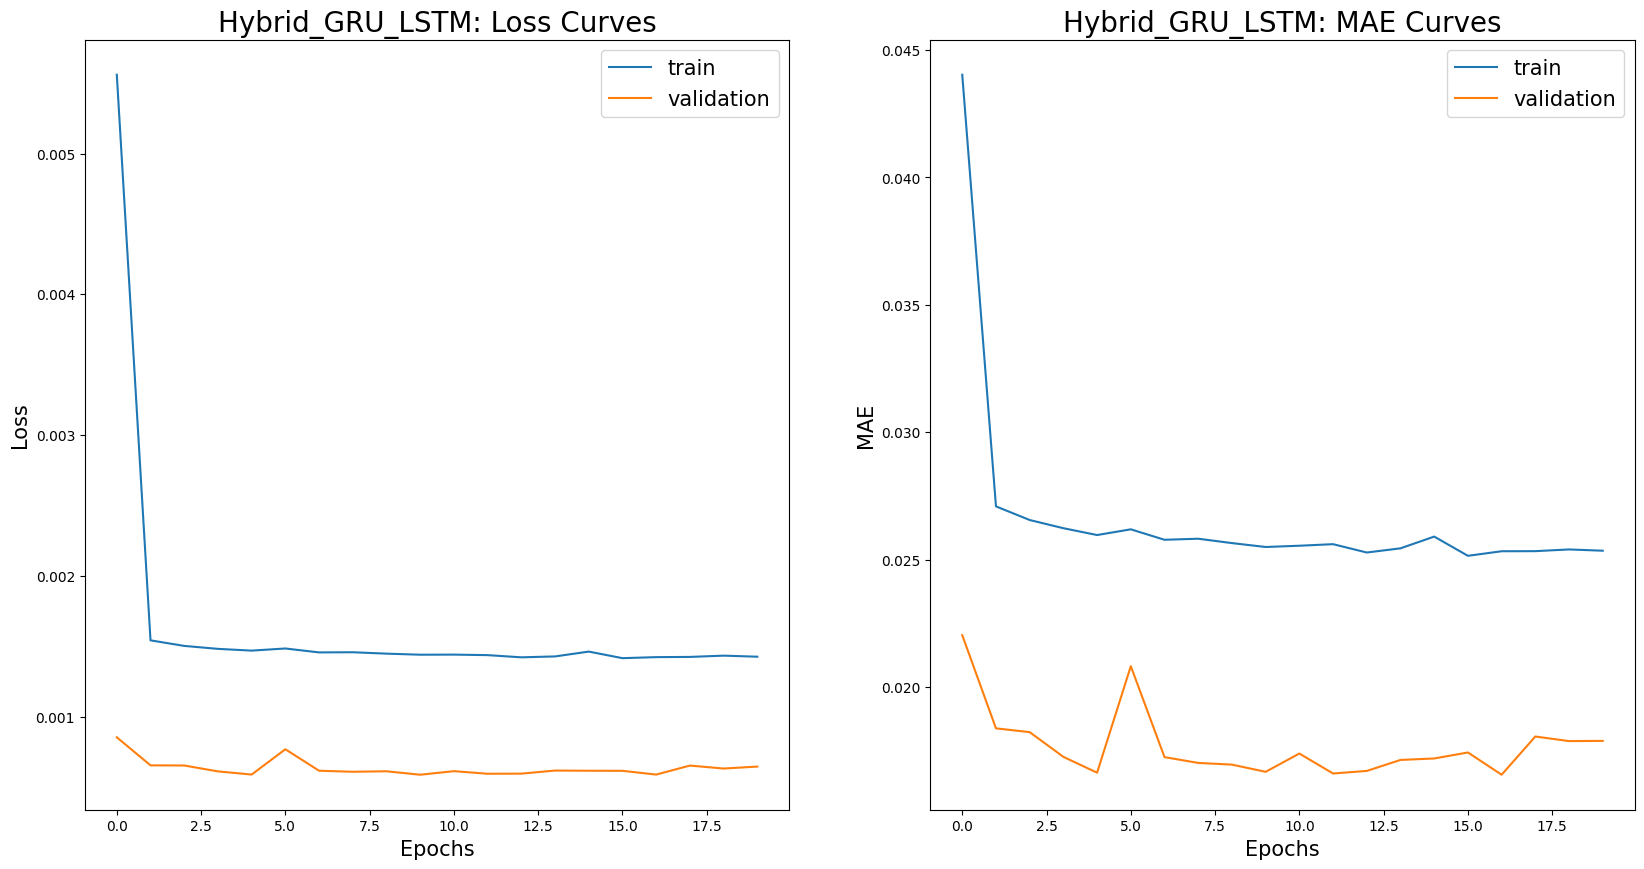

In [50]:
summarize_price_model_diagnostics(model, history)

In [51]:
y_pred = model.predict(X_test).flatten()

mse  = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r_mse = rmse(y_test, y_pred)

print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {r_mse:.6f}")
print(f"Test MAE : {mae:.6f}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Test MSE : 0.001091
Test RMSE: 0.033023
Test MAE : 0.022499


## window size = 90

In [55]:
X_train, y_train, X_val, y_val, X_test, y_test = build_panel_dataset(
        df_scaled,
        feature_cols,
        TARGET_COL,
        WINDOW_SIZE,
        TEST_RATIO,
        VAL_RATIO
    )

Total tickers: 10
Final shapes:
  X_train: (14721, 90, 16) y_train: (14721,)
  X_val  : (1633, 90, 16) y_val  : (1633,)
  X_test : (4079, 90, 16) y_test : (4079,)


In [56]:
# Build model
input_shape = (WINDOW_SIZE, len(feature_cols))
model_w90 = build_hybrid_gru_lstm(input_shape)
model_w90.summary()

# Train model
es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_w90 = model_w90.fit(
    X_train, y_train,
    validation_data=(X_val, y_val) if len(X_val) else None,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=2
)

Model: "Hybrid_GRU_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 90, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 90, 128)        │        56,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 195,969 (765.50 KB)

 Trainable params: 195,969 (765.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
231/231 - 51s - 220ms/step - loss: 0.0049 - mae: 0.0418 - val_loss: 6.2064e-04 - val_mae: 0.0170
Epoch 2/30
231/231 - 46s - 199ms/step - loss: 0.0015 - mae: 0.0266 - val_loss: 0.0011 - val_mae: 0.0273
Epoch 3/30
231/231 - 46s - 199ms/step - loss: 0.0015 - mae: 0.0267 - val_loss: 6.4769e-04 - val_mae: 0.0180
Epoch 4/30
231/231 - 47s - 201ms/step - loss: 0.0015 - mae: 0.0259 - val_loss: 0.0010 - val_mae: 0.0256
Epoch 5/30
231/231 - 47s - 203ms/step - loss: 0.0015 - mae: 0.0261 - val_loss: 6.6596e-04 - val_mae: 0.0183
Epoch 6/30
231/231 - 46s - 199ms/step - loss: 0.0015 - mae: 0.0262 - val_loss: 0.0011 - val_mae: 0.0265
Epoch 7/30
231/231 - 46s - 200ms/step - loss: 0.0014 - mae: 0.0256 - val_loss: 6.0994e-04 - val_mae: 0.0168
Epoch 8/30
231/231 - 46s - 200ms/step - loss: 0.0015 - mae: 0.0265 - val_loss: 8.8296e-04 - val_mae: 0.0229
Epoch 9/30
231/231 - 46s - 200ms/step - loss: 0.0014 - mae: 0.0256 - val_loss: 6.1351e-04 - val_mae: 0.0169
Epoch 10/30
231/231 - 46s - 201ms/step -

In [57]:
y_pred = model.predict(X_test).flatten()

mse  = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r_mse = rmse(y_test, y_pred)

print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {r_mse:.6f}")
print(f"Test MAE : {mae:.6f}")

128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step
Test MSE : 0.001103
Test RMSE: 0.033204
Test MAE : 0.022630


## Change window size to 90 and add more layers

In [ ]:
############ change window size to 90 ###################
WINDOW_SIZE = 30  

In [59]:
def build_hybrid_gru_lstm2(input_shape):
    """
    input_shape: (WINDOW_SIZE, num_features)

    Input
      → GRU(128, return_sequences=True) + Dropout(0.2)
      → LSTM(128) + Dropout(0.2)
      → Dense(64, relu)
      → Dense(1, linear)
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.GRU(
        128,
        return_sequences=True,
        dropout=DROPOUT_RATE
    )(inputs)

    x = layers.GRU(
        64,
        return_sequences=True,
        dropout=DROPOUT_RATE
   )(x)

    x = layers.LSTM(
        64,
        return_sequences=True,
        dropout=DROPOUT_RATE
    )(x)

    x = layers.LSTM(
        32,
        dropout=DROPOUT_RATE
    )(x)

    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="Hybrid_GRU_LSTM")

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    return model

In [60]:
# Build model
input_shape = (WINDOW_SIZE, len(feature_cols))
model_w90 = build_hybrid_gru_lstm2(input_shape)
model_w90.summary()

# Train model
es = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_w90 = model_w90.fit(
    X_train, y_train,
    validation_data=(X_val, y_val) if len(X_val) else None,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=2
)

Model: "Hybrid_GRU_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 90, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 90, 128)        │        56,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 90, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 90, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,929 (550.50 KB)

 Trainable params: 140,929 (550.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
231/231 - 62s - 267ms/step - loss: 0.0056 - mae: 0.0404 - val_loss: 0.0014 - val_mae: 0.0317
Epoch 2/30
231/231 - 53s - 229ms/step - loss: 0.0015 - mae: 0.0267 - val_loss: 7.0472e-04 - val_mae: 0.0193
Epoch 3/30
231/231 - 52s - 225ms/step - loss: 0.0014 - mae: 0.0256 - val_loss: 6.2340e-04 - val_mae: 0.0173
Epoch 4/30
231/231 - 52s - 225ms/step - loss: 0.0014 - mae: 0.0256 - val_loss: 0.0011 - val_mae: 0.0263
Epoch 5/30
231/231 - 52s - 225ms/step - loss: 0.0015 - mae: 0.0263 - val_loss: 6.0373e-04 - val_mae: 0.0167
Epoch 6/30
231/231 - 52s - 223ms/step - loss: 0.0014 - mae: 0.0254 - val_loss: 7.9485e-04 - val_mae: 0.0209
Epoch 7/30
231/231 - 51s - 221ms/step - loss: 0.0014 - mae: 0.0255 - val_loss: 0.0011 - val_mae: 0.0275
Epoch 8/30
231/231 - 51s - 221ms/step - loss: 0.0015 - mae: 0.0258 - val_loss: 6.9270e-04 - val_mae: 0.0188
Epoch 9/30
231/231 - 51s - 222ms/step - loss: 0.0014 - mae: 0.0254 - val_loss: 6.2732e-04 - val_mae: 0.0174
Epoch 10/30
231/231 - 51s - 220ms/step -

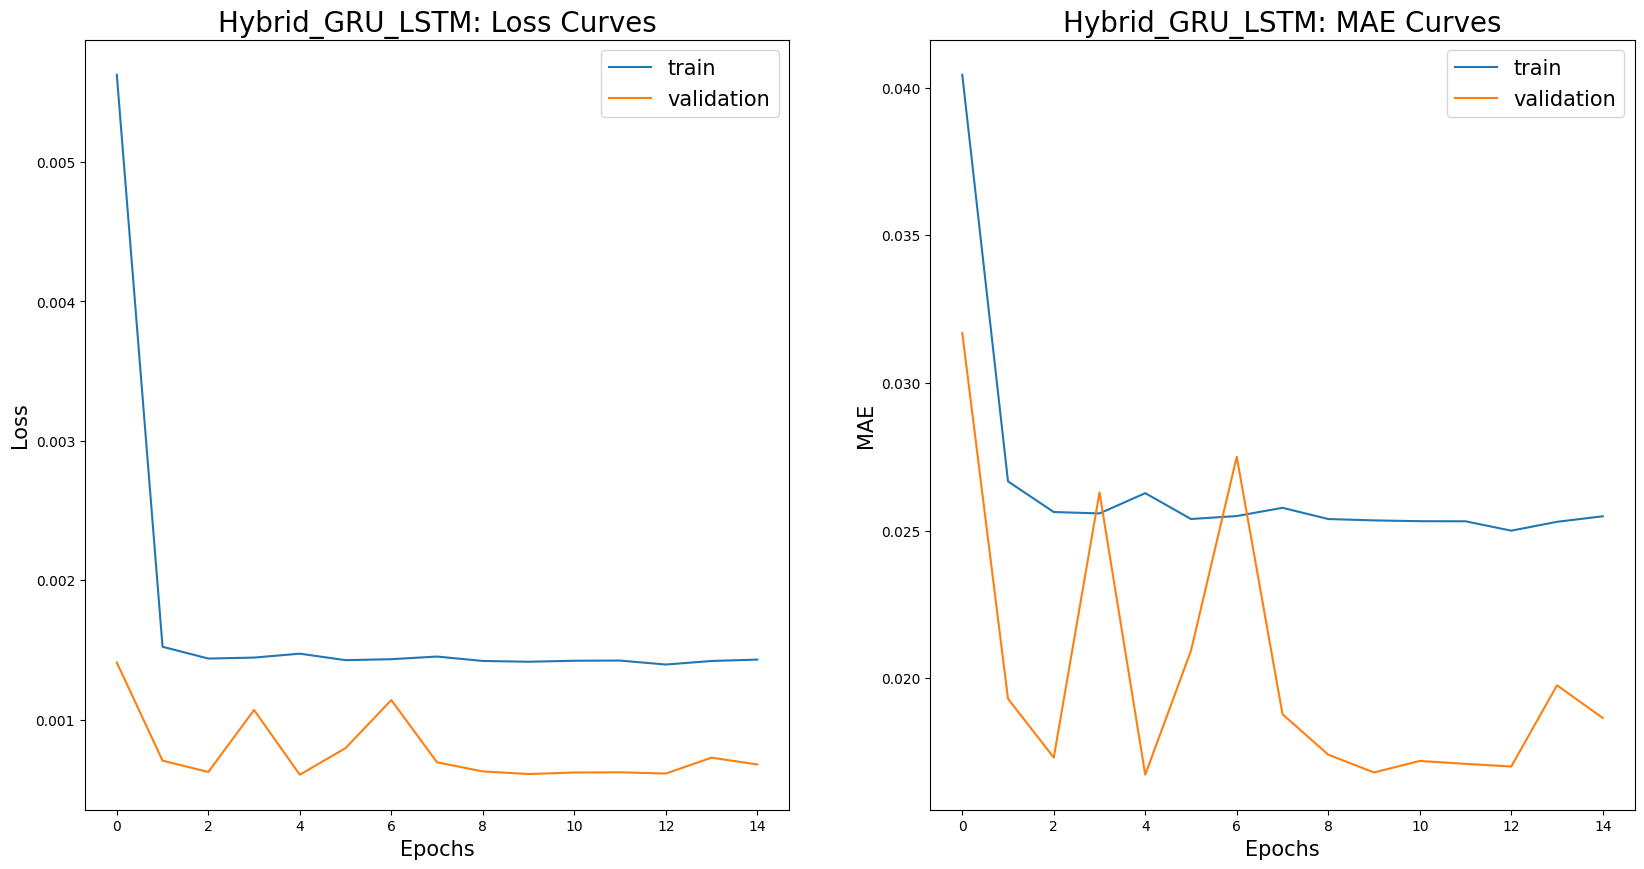

In [62]:
summarize_price_model_diagnostics(model_w90, history_w90)

In [63]:
y_pred = model_w90.predict(X_test).flatten()

mse  = mean_squared_error(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
r_mse = rmse(y_test, y_pred)

print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {r_mse:.6f}")
print(f"Test MAE : {mae:.6f}")

128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step
Test MSE : 0.001099
Test RMSE: 0.033147
Test MAE : 0.022538
